In [89]:
import pandas as pd
from scipy import stats
import numpy as np
import requests
from config import rapid_api_key, gkey
import gmaps
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
historical_stock_prices = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')

In [3]:
historical_stocks = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [244]:
combined_stocks_df = pd.merge(historical_stock_prices, historical_stocks, on='ticker', how='inner')
currently_trading_ticker = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']['ticker'].values
currently_trading_df = combined_stocks_df[combined_stocks_df['ticker'].isin(currently_trading_ticker)]
cleaned_currently_trading_df = currently_trading_df.dropna(axis=0)
sorted_current_trading = cleaned_currently_trading_df.sort_values(['date','ticker'])
sorted_current_trading = sorted_current_trading.reset_index()
sorted_current_trading.head()

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,14218004,AA,7.1409,7.1409,1.9863,7.1409,7.2250,22500,1970-01-02,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
1,9736426,AEP,30.1250,30.6250,0.9834,30.1250,31.0000,10300,1970-01-02,NYSE,"AMERICAN ELECTRIC POWER COMPANY, INC.",PUBLIC UTILITIES,ELECTRIC UTILITIES: CENTRAL
2,15855608,ARNC,6.6998,6.6998,1.8457,6.6998,6.7701,24100,1970-01-02,NYSE,ARCONIC INC.,CAPITAL GOODS,METAL FABRICATIONS
3,15427303,BA,0.9259,0.9794,0.2293,0.9259,0.9794,634400,1970-01-02,NYSE,BOEING COMPANY (THE),CAPITAL GOODS,AEROSPACE
4,12465494,CAT,3.5417,3.4583,0.3785,3.4479,3.5417,276000,1970-01-02,NYSE,"CATERPILLAR, INC.",CAPITAL GOODS,CONSTRUCTION/AG EQUIPMENT/TRUCKS


In [13]:
#Drop rows prior to year 2000
df_cleaned_2000 = sorted_current_trading.drop(sorted_current_trading.index[:4649822])
df_cleaned_2000 = df_cleaned_2000.reset_index()
del df_cleaned_2000['index']
df_cleaned_2000.head()

,level_0,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,4649822,A,56.330471,51.502148,44.991753,48.193848,56.464592,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,4649823,AA,99.724503,96.840897,71.915710,96.408363,100.157043,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,4649824,AABA,110.730453,118.750000,118.750000,107.375000,119.250000,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,4649825,AAME,2.375000,2.312500,2.154104,2.250000,2.437500,5100,2000-01-03,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4,4649826,AAN,5.370370,5.222222,4.541568,5.222222,5.370370,20800,2000-01-03,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES


In [14]:
#Suppress scientific notation
pd.options.display.float_format = '{:.4f}'.format

#View summary stats about year 2000 stocks
df_cleaned_2000.describe()

,level_0,open,close,adj_close,low,high,volume
count,13492562.0000,13492562.0000,13492562.0000,13492562.0000,13492562.0000,13492562.0000,13492562.0000
mean,11396102.5000,92.9606,93.0266,89.0413,90.6223,95.4866,1377768.1135
std,3894967.2957,3354.6054,3380.8610,3377.6582,3227.7733,3539.3432,6162169.3825
min,4649822.0000,0.0004,0.0002,0.0000,0.0001,0.0004,1.0000
25%,8022962.2500,9.1800,9.1800,7.6158,9.0000,9.3700,35900.0000
50%,11396102.5000,19.3737,19.3740,16.0000,19.0400,19.6900,207900.0000
75%,14769242.7500,35.9000,35.9000,30.9627,35.3500,36.4000,880300.0000
max,18142383.0000,2034000.0000,1779750.0000,1779750.0000,1440000.0000,2070000.0000,1855410200.0000


In [15]:
#Identify outliers based on average volume for year 2000
Q1_vol = df_cleaned_2000['volume'].quantile(0.25)
Q3_vol = df_cleaned_2000['volume'].quantile(0.75)
vol_IQR = Q3_vol - Q1_vol

#Filter rows where volume is considered a low outlier
df_2000_no_out = df_cleaned_2000.loc[df_cleaned_2000['volume'] > Q1_vol]
df_2000_no_out = df_2000_no_out.reset_index(drop=True)
del df_2000_no_out['level_0']
df_2000_no_out.head()

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,A,56.3305,51.5021,44.9918,48.1938,56.4646,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,AA,99.7245,96.8409,71.9157,96.4084,100.1570,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,AABA,110.7305,118.7500,118.7500,107.3750,119.2500,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,AAON,1.2949,1.1852,0.7780,1.1852,1.2949,683700,2000-01-03,NASDAQ,"AAON, INC.",CAPITAL GOODS,INDUSTRIAL MACHINERY/COMPONENTS
4,AAPL,3.7455,3.9978,2.6865,3.6317,4.0179,133949200,2000-01-03,NASDAQ,APPLE INC.,TECHNOLOGY,COMPUTER MANUFACTURING


In [16]:
# Stock data beginning year 2000
df_cleaned_2000_boy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-01-03']
df_cleaned_2000_boy = df_cleaned_2000_boy.reset_index()
del df_cleaned_2000_boy['index']
df_cleaned_2000_boy.head()

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,A,56.3305,51.5021,44.9918,48.1938,56.4646,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,AA,99.7245,96.8409,71.9157,96.4084,100.1570,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,AABA,110.7305,118.7500,118.7500,107.3750,119.2500,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,AAON,1.2949,1.1852,0.7780,1.1852,1.2949,683700,2000-01-03,NASDAQ,"AAON, INC.",CAPITAL GOODS,INDUSTRIAL MACHINERY/COMPONENTS
4,AAPL,3.7455,3.9978,2.6865,3.6317,4.0179,133949200,2000-01-03,NASDAQ,APPLE INC.,TECHNOLOGY,COMPUTER MANUFACTURING


In [17]:
# Stock data end year 2000
df_cleaned_2000_eoy = df_2000_no_out.loc[df_2000_no_out['date']=='2000-12-29']
df_cleaned_2000_eoy = df_cleaned_2000_eoy.reset_index()
del df_cleaned_2000_eoy['index']
df_cleaned_2000_eoy.head()

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,A,39.6102,39.1631,34.2125,38.3584,40.3702,2069300,2000-12-29,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,AA,82.4710,80.0680,60.4071,79.8757,82.4710,1031900,2000-12-29,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
2,AABA,15.1562,15.0312,15.0312,14.7812,15.5938,20893400,2000-12-29,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
3,AAME,1.7656,2.0000,1.8630,1.7500,2.0000,45300,2000-12-29,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4,AAON,1.5473,1.5528,1.0194,1.5473,1.6461,132400,2000-12-29,NASDAQ,"AAON, INC.",CAPITAL GOODS,INDUSTRIAL MACHINERY/COMPONENTS


In [18]:
# Beginning of year and end of year data
full_year_2000 = pd.merge(df_cleaned_2000_boy, df_cleaned_2000_eoy, on=['ticker'], how='inner')
full_year_2000 = full_year_2000[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2000['yearly_value_change'] = full_year_2000['adj_close_y'] - full_year_2000['open_x']
full_year_2000 = full_year_2000[['ticker', 'name_x', 'yearly_value_change']]
full_year_2000.head()

,ticker,name_x,yearly_value_change
0,A,"AGILENT TECHNOLOGIES, INC.",-22.1180
1,AA,ALCOA CORPORATION,-39.3174
2,AABA,ALTABA INC.,-95.6992
3,AAON,"AAON, INC.",-0.2755
4,AAPL,APPLE INC.,-3.0315


In [19]:
# Worst stocks in terms of per-share value from beginning of year to end of year
asc_2000_yearly_change = full_year_2000.sort_values(['yearly_value_change'])
neg_year_change_2000 = asc_2000_yearly_change[:100]
neg_year_change_2000 = neg_year_change_2000.reset_index(drop=False)
neg_year_change_2000.head()

,index,ticker,name_x,yearly_value_change
0,435,GEC,"GREAT ELM CAPITAL GROUP, INC.",-3020.0051
1,938,STCN,"STEEL CONNECT, INC.",-1413.0779
2,673,MSTR,MICROSTRATEGY INCORPORATED,-1060.0000
3,127,BCOR,"BLUCORA, INC.",-533.2501
4,40,AKAM,"AKAMAI TECHNOLOGIES, INC.",-323.1250


In [20]:
# Best stocks in terms of per-share value from beginning of year to end of year
desc_2000_yearly_change = full_year_2000.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2000 = desc_2000_yearly_change[:100]
pos_year_change_2000 = pos_year_change_2000.reset_index(drop=False)
del pos_year_change_2000['index']
pos_year_change_2000.head()

,ticker,name_x,yearly_value_change
0,CIEN,CIENA CORPORATION,364.4375
1,TTNP,"TITAN PHARMACEUTICALS, INC.",89.7050
2,SANM,SANMINA CORPORATION,78.9375
3,EMKR,EMCORE CORPORATION,76.4815
4,NVR,"NVR, INC.",75.8500


In [23]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2000['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Obtain coordinates for ticker address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)

figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2000 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)
fig_2000.add_layer(heat_layer)
fig_2000

In [46]:
#Dataframe for stocks from Aug 2017 - Aug 2018
df_cleaned_2018 = sorted_current_trading.loc[sorted_current_trading['date'] >= '2017-08-24']
df_cleaned_2018 = df_cleaned_2018.reset_index()
del df_cleaned_2018['index']
del df_cleaned_2018['level_0']
Q1_2018_vol = df_cleaned_2018['volume'].quantile(0.25)
df_2018_no_out = df_cleaned_2018.loc[df_cleaned_2018['volume'] > Q1_2018_vol]
df_2018_no_out = df_2018_no_out.reset_index(drop=True)

# Stock data beginning year Aug 2017
df_cleaned_2018_boy = df_2018_no_out.loc[df_2018_no_out['date']=='2017-08-24']
df_cleaned_2018_boy = df_cleaned_2018_boy.reset_index(drop=True)

# Stock data end year Aug 2018
df_cleaned_2018_eoy = df_2018_no_out.loc[df_2018_no_out['date']=='2018-08-24']
df_cleaned_2018_eoy = df_cleaned_2018_eoy.reset_index(drop=True)

# Beginning of 2017 year and end of 2018 year data
full_year_2018 = pd.merge(df_cleaned_2018_boy, df_cleaned_2018_eoy, on=['ticker'], how='inner')
full_year_2018 = full_year_2018[['ticker', 'name_x', 'exchange_x', 'sector_x', 'industry_x', 'date_x', 'open_x', 'close_x', 'adj_close_x', 'volume_x', 'date_y',  'open_y', 'close_y', 'adj_close_y', 'volume_y']]
full_year_2018['yearly_value_change'] = full_year_2018['adj_close_y'] - full_year_2018['open_x']
full_year_2018 = full_year_2018[['ticker', 'name_x', 'yearly_value_change']]

# Worst stocks in terms of per-share value from beginning of year to end of year
asc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'])
neg_year_change_2018 = asc_2018_yearly_change[:100]
neg_year_change_2018 = neg_year_change_2018.reset_index(drop=False)
del neg_year_change_2018['index']

# Best stocks in terms of per-share value from beginning of year to end of year
desc_2018_yearly_change = full_year_2018.sort_values(['yearly_value_change'],ascending=False)
pos_year_change_2018 = desc_2018_yearly_change[:100]
pos_year_change_2018 = pos_year_change_2018.reset_index(drop=False)
del pos_year_change_2018['index']

In [51]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-summary"

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }

coordinates = []

for ticker in pos_year_change_2018['ticker'].values:    
    try:
        querystring = {"region":"US","symbol":ticker}
        tick_response = requests.get(url, headers=headers, params=querystring).json()
        tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city']
    except:
        continue        
    try:
        address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['state']
        address = ','.join(address)
    except KeyError as e:
        if e.args[0] == 'state':
            address = tick_response['summaryProfile']['address1'], tick_response['summaryProfile']['city'], tick_response['summaryProfile']['country']
            address = ','.join(address)
    
    # Obtain coordinates for ticker address
    target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
    geo_response = requests.get(target_url).json()
    city_lat = geo_response['results'][0]['geometry']['location']['lat']
    city_lng = geo_response['results'][0]['geometry']['location']['lng']
    city_tup = (city_lat, city_lng)
    coordinates.append(city_tup)
    
figure_layout = {
    'width': '1500px',
    'height': '900px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}
gmaps.configure(api_key=gkey)
fig_2018 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, dissipating=False, max_intensity=3, point_radius=2)

fig_2018.add_layer(heat_layer)
fig_2018

Figure(layout=FigureLayout(height='420px'))

In [245]:
#ticker_group = df_cleaned_2018.groupby('ticker')
#avg_volume = ticker_group['volume'].mean()
#avg_vol_df = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)
#avg_vol_df = avg_vol_df.reset_index()
#avg_vol_df = avg_vol_df.rename(columns={'volume':'average_volume_2018'})

#df_cleaned_2018['daily_net_return'] = df_cleaned_2018['close'] - df_cleaned_2018['open']
#df_cleaned_2018 = df_cleaned_2018.loc[(df_cleaned_2018['daily_net_return'] < 2) & (df_cleaned_2018['daily_net_return'] > -2)]
#daily_return_group = df_cleaned_2018.groupby('ticker')
#daily_net_ret = daily_return_group['daily_net_return'].mean()
#daily_net_ret_df = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)
#daily_net_ret_df = daily_net_ret_df.reset_index()

#vol_return_2018 = pd.merge(avg_vol_df, daily_net_ret_df, on='ticker', how='inner')

#plt.scatter(vol_return_2018['daily_net_return'], vol_return_2018['average_volume_2018'] / 10000000)
#plt.xlabel('Average Daily Net Return Per Share')
#plt.ylabel('Average Transaction Volume (Tens of Millions)')

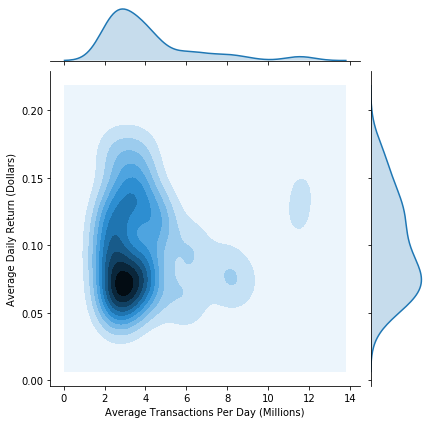

In [159]:
top_500_net_ret = pd.DataFrame(daily_net_ret).sort_values('daily_net_return', ascending=False)[:500]
Q1_net_ret = top_500_net_ret['daily_net_return'].quantile(0.25)
Q3_net_ret = top_500_net_ret['daily_net_return'].quantile(0.75)
IQR_net_ret = Q3_net_ret - Q1_net_ret
clean_net_ret = top_500_net_ret.loc[(top_500_net_ret['daily_net_return'] > (Q1_net_ret - 1.5 * IQR_net_ret)) & (top_500_net_ret['daily_net_return'] < (Q3_net_ret + 1.5 * IQR_net_ret))]

top_500_avg_vol = pd.DataFrame(avg_volume).sort_values('volume', ascending=False)[:500]
Q1_avg_vol = top_500_avg_vol['volume'].quantile(0.25)
Q3_avg_vol = top_500_avg_vol['volume'].quantile(0.75)
IQR_avg_vol = Q3_avg_vol - Q1_avg_vol
clean_avg_vol = top_500_avg_vol.loc[(top_500_avg_vol['volume'] > (Q1_avg_vol - 1.5 * IQR_avg_vol)) & (top_500_avg_vol['volume'] < (Q3_avg_vol + 1.5 * IQR_avg_vol))]

clean_vol_return_2018 = pd.merge(clean_avg_vol, clean_net_ret, on='ticker', how='inner')
clean_vol_return_2018['volume'] = clean_vol_return_2018['volume'] / 1000000
clean_vol_return_2018 = clean_vol_return_2018.rename(columns={'volume': 'Average Transactions Per Day (Millions)',
                                     'daily_net_return': 'Average Daily Return (Dollars)'})

sns.jointplot(x=clean_vol_return_2018['Average Transactions Per Day (Millions)'], y=clean_vol_return_2018['Average Daily Return (Dollars)'], kind="kde");

Please enter a US stock ticker: FB


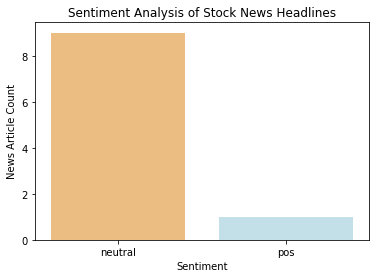

In [243]:
news_url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-news"
user_stock = input('Please enter a US stock ticker: ')
news_querystring = {"region":"US","category":user_stock}
news_headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapid_api_key
    }
response = requests.get(news_url, headers=news_headers, params=news_querystring).json()

text_url = 'http://text-processing.com/api/sentiment/'

news_response = response['items']['result']

stock_classifications = []

for news in news_response:
    title = news['title']
    sentiment_data = {'text':title}
    sentiment_response = requests.post(url=text_url, data=sentiment_data).json()
    stock_classifications.append(sentiment_response['label'])
    
sns.countplot(x=stock_classifications, palette='RdYlBu')
plt.title('Sentiment Analysis of Stock News Headlines')
plt.xlabel('Sentiment')
plt.ylabel('News Article Count');